# Jail Breaking Deep Learning Models
In this Project we will be working on launching effective adversarial attacks on production grade, publicly posted models, and degrade their performance. We will be performing attacks against ResNet-34 and DenseNet-121 models that are trained to classify the ImageNet-1K dataset.

In [32]:
# Importing all the relevant Libraries
import os, json, random, math

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = {
    "resnet38":   {},
    "densenet121": {}
}

Using device: cuda


We will be using a subset of images taken from 100 classes of the ImageNet-1K dataset.

In [3]:
!unzip -q TestDataSet.zip

## Task 1: Evaluate the pre-trained ResNet-34 model on this test dataset

In [4]:
# 1. Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 149MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# 2. Prepare data
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 3. Load the Primary Dataset
primary_dataset = torchvision.datasets.ImageFolder("./TestDataSet", transform=transform)
loader  = DataLoader(primary_dataset, batch_size=1, shuffle=False)

# 4. Build a remap output
# JSON is a list of strings "401: accordion", "402: acoustic guitar", … in the same order
with open("./TestDataSet/labels_list.json") as f:
    entries = json.load(f)

# parse out just the integer labels
label_indices = [int(e.split(":",1)[0]) for e in entries]
remap = torch.tensor(label_indices, dtype=torch.long, device=device)
# now remap[i] == true ImageNet idx for folder-index i

# Subsetting names for Prediction Visualization
subset_names = []
im_to_subset = {}
for subset_idx, entry in enumerate(entries):
    im_idx_str, name = entry.split(":", 1)
    im_idx = int(im_idx_str.strip())
    name   = name.strip()
    subset_names.append(name)
    im_to_subset[im_idx] = subset_idx

In [10]:
# Function to Evaluate a Model against the Dataset
def evaluate(model, loader, device):
    top1 = 0
    top5 = 0
    total = 0

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            true_lbl = remap[lbls]                   # [B]

            logits = model(imgs)                     # [B,1000]
            _, top5_idx = logits.topk(5, dim=1)      # [B,5]

            top1 += (top5_idx[:,0] == true_lbl).sum().item()
            top5 += (top5_idx.eq(true_lbl.view(-1,1))
                            .any(dim=1)
                            .sum()
                            .item())
            total += lbls.size(0)

    print(f"Top-1 Accuracy: {top1/total*100:.2f}% ({top1}/{total})")
    print(f"Top-5 Accuracy: {top5/total*100:.2f}% ({top5}/{total})")
    return {"top1": top1/total*100, "top5": top5/total*100},

In [14]:
# 5. Evaluate the Initial Model (ResNet-34) against the dataset
stats = evaluate(model, loader, device)
results["resnet38"]["Base"] = stats

Top-1 Accuracy: 76.00% (380/500)
Top-5 Accuracy: 94.20% (471/500)


In [17]:
# Denormalize to display images
def denorm(img):
    return (img.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0)

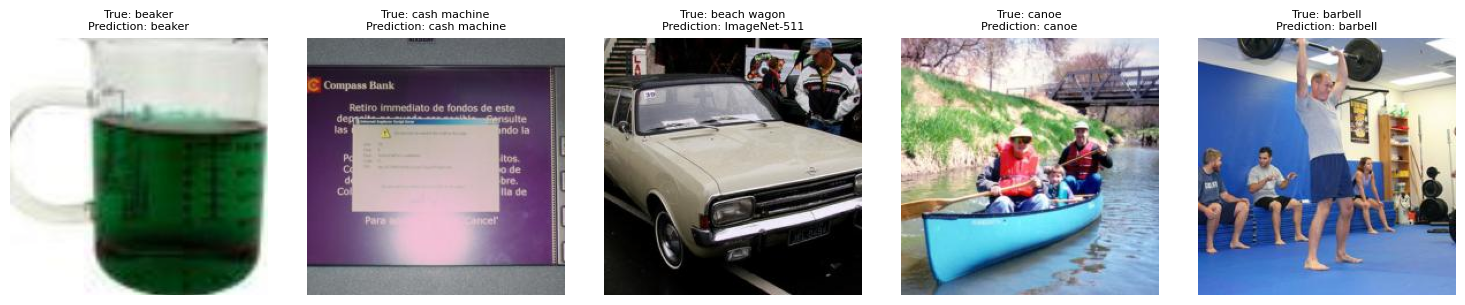

In [16]:
# 6. Visulize results from initial Model
idxs = random.sample(range(len(primary_dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = primary_dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow(denorm(img_norm))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

## Task 2: Evaluate the ResNet-34 Model against Pixel-Wise Attack (FGSM)
A common and simple algorithm for mounting an **L∞ attack** is called **Fast Gradient Sign Method (FGSM)**. This implements a single step of gradient ascent (in pixel space) and truncates the values of the gradients to at most **ε**. Mathematically, we can write this as:

$$
x \leftarrow x + \varepsilon \cdot \text{sign}\left( \nabla_x L \right)
$$





In [18]:
# 1. Generating the dataset for Adversarial Attack

# Hyperparams & paths
epsilon = 0.02  # max change in [0,1] pixel space
root     = "./TestDataSet"
adv_root = "./Adversarial_TestSet1"

# Prepare per-channel epsilon in normalized space: δ_norm[c] = ε / std[c]
eps = torch.tensor([epsilon/s for s in std], device=device).view(1,3,1,1)

# Criterion for Loss
criterion = torch.nn.CrossEntropyLoss()

# make dirs
os.makedirs(adv_root, exist_ok=True)
for syn in primary_dataset.classes:
    os.makedirs(os.path.join(adv_root, syn), exist_ok=True)

for (img, lbl), (path, _) in zip(DataLoader(primary_dataset, batch_size=1), primary_dataset.samples):
    img = img.to(device)
    lbl = lbl.to(device)
    img.requires_grad_()

    # 1) forward + loss
    out  = model(img)
    tgt  = remap[lbl].view(1)
    loss = criterion(out, tgt)
    loss.backward()

    # 2) FGSM step in normalized space with channel-wise eps
    adv = img + eps * img.grad.sign()

    # 3) clamp so we never move more than ±ε in normalized space
    adv = torch.max(torch.min(adv, img + eps), img - eps)

    # 4) clamp to valid normalized image range
    for c,(m,s) in enumerate(zip(mean,std)):
        low  = (0.0 - m)/s
        high = (1.0 - m)/s
        adv[0,c].clamp_(low, high)

    # 5) denormalize back to [0,1] and save
    denorm = adv.detach().cpu()[0]
    for c,(m,s) in enumerate(zip(mean,std)):
        denorm[c] = denorm[c]*s + m
    denorm.clamp_(0,1)

    fname = os.path.basename(path)
    torchvision.utils.save_image(
        denorm,
        os.path.join(adv_root, primary_dataset.classes[lbl], fname)
    )

In [19]:
# 2. Load the Attacked data set
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet1", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

In [20]:
# 3. Evaluate the ResNet-34 Model against the attacked Dataset
stats = evaluate(model, loader, device)
results["resnet38"]["FGSM"] = stats

Top-1 Accuracy: 6.40% (32/500)
Top-5 Accuracy: 33.00% (165/500)


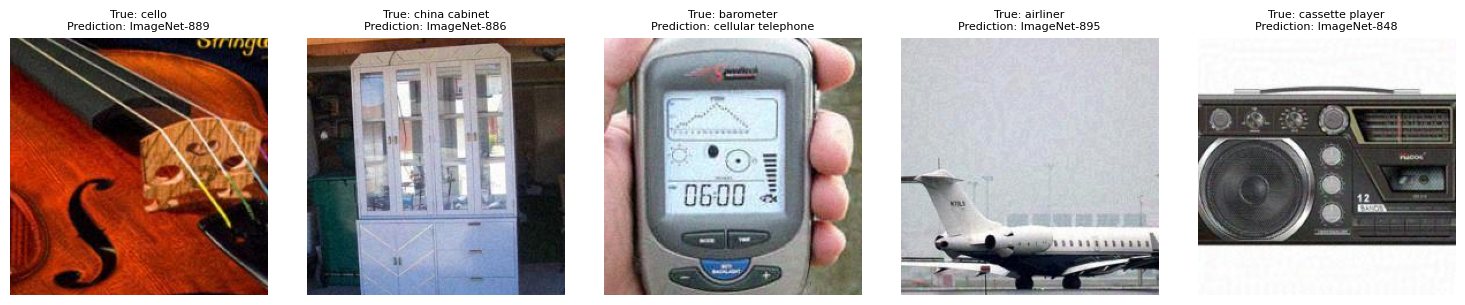

In [23]:
# 4. Visualize the results after Adversarial Attack
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

## Task 3: Evaluate the ResNet-34 Model against an improved Attack

Momentum Iterative FGSM (MI-FGSM) is a white-box, L∞-bounded adversarial attack that refines the classic PGD loop by adding an exponential moving average of past gradients.
At each step, the current gradient is normalised, accumulated with momentum, and its sign is taken to update the image before re-projecting into the ε-cube around the original.
The momentum term smooths the search trajectory, escaping local oscillations and boosting both success rate and cross-model transferability.
With ε = 0.02 and 10 steps, this implementation perturbs every pixel just enough to fool the network while keeping changes imperceptible to humans

In [24]:
# 1. Generating the dataset for an improved Adversarial Attack

# Hyperparams & paths
epsilon     = 0.02  # max change in [0,1] pixel space
num_steps   = 10
_alpha      = epsilon / num_steps
root     = "./TestDataSet"
adv_root = "./Adversarial_TestSet2"


# Prepare per-channel epsilon in normalized space: δ_norm[c] = epsilon / std[c]
eps = torch.tensor([epsilon/s for s in std], device=device).view(1,3,1,1)
alpha = torch.tensor([_alpha/s for s in std], device=device).view(1,3,1,1)

eps   = eps.to(img.dtype)
alpha = alpha.to(img.dtype)

# Criterion for Loss
criterion = torch.nn.CrossEntropyLoss()

# make dirs
os.makedirs(adv_root, exist_ok=True)
for syn in primary_dataset.classes:
    os.makedirs(os.path.join(adv_root, syn), exist_ok=True)

for (img, lbl), (path, _) in zip(DataLoader(primary_dataset, batch_size=1, shuffle=False), primary_dataset.samples):
    img = img.to(device)
    lbl = lbl.to(device)
    tgt  = remap[lbl].view(1)

    adv = img.clone().detach()

    # 1. momentum-decay factor (1.0 = keep full history)
    decay = 1.0

    g_accum = torch.zeros_like(adv)

    # 2. PGD iterations
    for steps in range(num_steps):
        adv.requires_grad_()
        model.zero_grad()
        loss = criterion(model(adv), tgt)
        loss.backward()

        # 3. L1-normalise gradient
        # exponential moving average (momentum term)
        # gradient-sign step with momentum scaling

        g = adv.grad / adv.grad.abs().mean(dim=[1,2,3], keepdim=True)
        g_accum = decay * g_accum + g
        adv = adv + alpha * g_accum.sign()
        adv = torch.max(torch.min(adv, img + eps), img - eps)
        adv = adv.detach()

    # 4) clamp to valid normalized image range
    for c,(m,s) in enumerate(zip(mean,std)):
        low  = (0.0 - m) / s
        high = (1.0 - m) / s
        adv[0, c].clamp_(low, high)

    # 5) denormalize back to [0,1] and save
    denorm = adv.cpu()[0]
    for c,(m,s) in enumerate(zip(mean,std)):
        denorm[c] = denorm[c] * s + m
    denorm.clamp_(0,1)

    fname = os.path.basename(path)
    torchvision.utils.save_image(
        denorm,
        os.path.join(adv_root, primary_dataset.classes[lbl], fname)
    )

In [25]:
# 2. Load the improved Attacked data set
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet2", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

In [26]:
# 3. Evaluate the ResNet-34 Model against the improved attacked Dataset
stats = evaluate(model, loader, device)
results["resnet38"]["MI-FGSM"] = stats

Top-1 Accuracy: 0.00% (0/500)
Top-5 Accuracy: 12.00% (60/500)


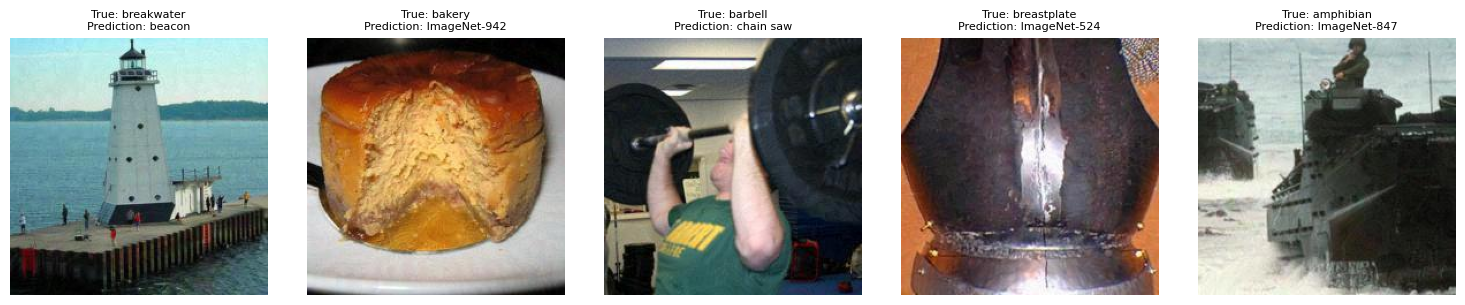

In [27]:
# 4. Visualize the results after improved Attack
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

## Task 4: Patch Attack based on MI-FGSM

The 32 × 32 patch Momentum Iterative FGSM (MI-FGSM) is a white-box, L∞-bounded attack that localises the perturbation to a small square window while still leveraging the momentum-enhanced PGD loop.
At every iteration, gradients are normalised, added to an exponential moving average, and the signed momentum update is applied only inside the chosen patch, the rest of the image remains unchanged.
After each step the patch is re-projected into the ε-cube around the corresponding region of the original image, ensuring the local perturbation never exceeds the 0.02 budget.
Because the modification is small confined yet iteratively refined, the patch can trigger mis-classification with minimal visual change.

In [28]:
# 1. Generating the dataset for an improved Adversarial Attack

# hyper-params & paths
epsilon     = 0.5          # L∞ budget (image space)
num_steps   = 35           # PGD iterations
patch       = 32           # patch size
decay       = 1.0          # MI-FGSM momentum

root     = "./TestDataSet"
adv_root = "./Adversarial_TestSet3"

# epsilon & alpha in normalised space
eps   = torch.tensor([epsilon/s for s in std], device=device).view(1,3,1,1).float()
alpha = eps / num_steps

# Criterion for Loss
criterion = torch.nn.CrossEntropyLoss()

# make dirs
os.makedirs(adv_root, exist_ok=True)
for syn in primary_dataset.classes:
    os.makedirs(os.path.join(adv_root, syn), exist_ok=True)

# The attack loop
for (img, lbl), (path, _) in zip(DataLoader(primary_dataset, batch_size=1, shuffle=False),
                                 primary_dataset.samples):
    img = img.to(device, dtype=torch.float32)
    lbl = lbl.to(device)
    tgt = remap[lbl].view(1)

    _, _, H, W = img.shape
    adv        = img.clone()
    g_accum    = torch.zeros_like(adv)

    for step in range(num_steps):
        # pick a random patch location each step
        y0 = torch.randint(0, H - patch + 1, (1,), device=device).item()
        x0 = torch.randint(0, W - patch + 1, (1,), device=device).item()

        mask = torch.zeros_like(adv)
        mask[:, :, y0:y0+patch, x0:x0+patch] = 1.0

        # MI-PGD step
        adv.requires_grad_(True)
        model.zero_grad()
        loss = criterion(model(adv), tgt)
        loss.backward()

        g = adv.grad / (adv.grad.abs().mean(dim=[1,2,3], keepdim=True) + 1e-12)
        g_accum = decay * g_accum + g                         # momentum
        step    = alpha * g_accum.sign() * mask               # update only in patch

        adv = adv + step
        adv = torch.clamp(adv, img - eps, img + eps).detach() # global ε-projection

    # 4) clamp to valid normalized image range
    for c,(m,s) in enumerate(zip(mean,std)):
        low, high = (0.0 - m)/s, (1.0 - m)/s
        adv[0,c].clamp_(low, high)

    # 5) denormalize back to [0,1] and save
    denorm = adv.cpu()[0]
    for c,(m,s) in enumerate(zip(mean,std)):
        denorm[c] = denorm[c]*s + m
    denorm.clamp_(0,1)

    fname = os.path.basename(path)
    torchvision.utils.save_image(
        denorm,
        os.path.join(adv_root, primary_dataset.classes[lbl], fname)
    )

In [29]:
# 2. Load the Patch Attacked Dataset
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet3", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

In [30]:
# 3. Evaluate against the Patch Attacked Dataset
stats = evaluate(model, loader, device)
results["resnet38"]["Patch MI-FGSM"] = stats

Top-1 Accuracy: 8.20% (41/500)
Top-5 Accuracy: 43.00% (215/500)


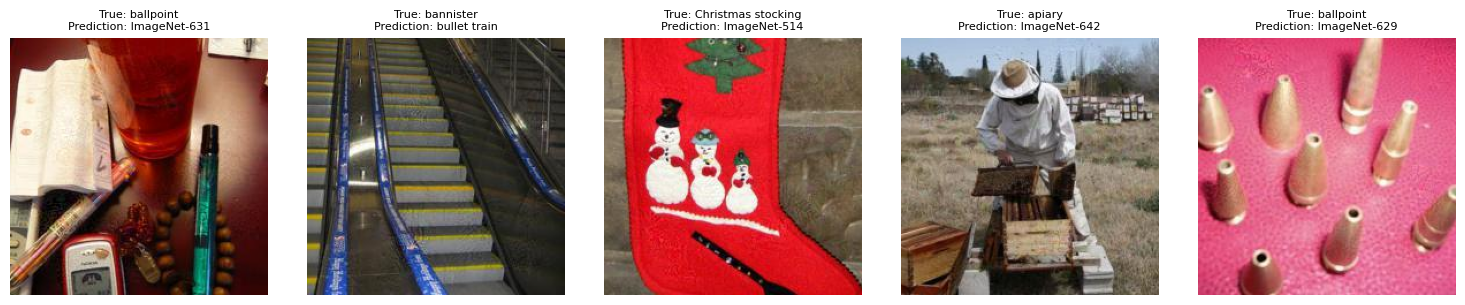

In [31]:
# 4. Visualize the results after patch Attack data
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

### Patch Attack Varaint 2 Center and Targetted
This attack launches from a uniformly random point inside the allowed L∞ ball, then applies Momentum Iterative Projected Gradient Descent while using a cosine-decay learning-rate schedule. At every iteration it re-selects both the 32 × 32 patch position and the target class, constantly steering the optimizer toward whichever misclassification is currently easiest to reach. Momentum smooths the gradient directions to speed convergence, and the gradually shrinking step size focuses the search as it nears the decision boundary. The combination of dynamic targets and locations, momentum, and cosine scheduling produces an adaptive, hard-to-defend adversarial perturbation that always remains within the ε constraint.

In [33]:
# hyper-parameters
epsilon   = 0.5          # L∞ budget (image space)
num_steps = 25           # PGD iterations
patch     = 32           # patch size
decay     = 1.0          # MI-FGSM momentum

root     = "./TestDataSet"
adv_root = "./Adversarial_TestSet4"

# ε and α in *normalised* space
eps   = torch.tensor([epsilon/s for s in std], device=device).view(1,3,1,1).float()
alpha = eps / num_steps                                       # tensor

criterion = torch.nn.CrossEntropyLoss()

# create output directory tree
os.makedirs(adv_root, exist_ok=True)
for syn in primary_dataset.classes:
    os.makedirs(os.path.join(adv_root, syn), exist_ok=True)

# highest-prob wrong class
def next_wrong_class(probs, true_idx):
    for c in probs.argsort(descending=True):
        if c.item() != true_idx:
            return c.item()
    return probs.argsort(descending=True)[1].item()   # fallback

# attack every image
for (img, lbl), (path, _) in zip(
        DataLoader(primary_dataset, batch_size=1, shuffle=False),
        primary_dataset.samples):

    img = img.to(device, dtype=torch.float32)          # (1,3,H,W)
    true_idx = remap[lbl].item()                       # scalar int
    _, _, H, W = img.shape

    # define a centre patch mask for the random start
    yc0, xc0 = (H - patch)//2, (W - patch)//2
    mask_center = torch.zeros_like(img)
    mask_center[:, :, yc0:yc0+patch, xc0:xc0+patch] = 1.0

    # random ε-bounded initialisation in centre patch
    delta0 = torch.empty_like(img).uniform_(-epsilon, epsilon) * mask_center
    adv    = torch.clamp(img + delta0, img - eps, img + eps).detach()

    g_accum = torch.zeros_like(adv)

    # MI-PGD loop
    for step in range(num_steps):
        # 1. dynamic target class
        adv.requires_grad_(True)
        logits = model(adv)
        probs  = torch.softmax(logits.detach(), dim=1)[0]
        tgt_idx = next_wrong_class(probs, true_idx)
        tgt_dyn = torch.tensor([tgt_idx], device=device)

        # 2) targeted loss  (negate CE)
        loss = -criterion(logits, tgt_dyn)
        loss.backward()
        grad = adv.grad

        # 3. saliency-guided patch placement
        sal = grad.abs().sum(dim=1, keepdim=True)            # (1,1,H,W)
        energy = torch.nn.functional.avg_pool2d(
                     sal, kernel_size=patch, stride=1) * (patch**2)
        flat_idx = energy.view(-1).argmax().item()
        energy_H, energy_W = energy.shape[-2:]
        y0 = flat_idx // energy_W
        x0 = flat_idx %  energy_W

        mask = torch.zeros_like(adv)
        mask[:, :, y0:y0+patch, x0:x0+patch] = 1.0

        # 4. MI-PGD signed update inside the patch
        g_norm  = grad / (grad.abs().mean(dim=[1,2,3], keepdim=True) + 1e-12)
        g_accum = decay * g_accum + g_norm

        # cosine-decayed step size
        lr_coeff = 0.5 * (1 + math.cos(math.pi * step / num_steps))
        alpha_step = alpha * lr_coeff

        adv = adv + alpha_step * g_accum.sign() * mask
        adv = torch.clamp(adv, img - eps, img + eps).detach()
        adv.grad = None                                       # clear graph

    #clamp back to valid range
    for c,(m,s) in enumerate(zip(mean, std)):
        low, high = (0.0 - m)/s, (1.0 - m)/s
        adv[0,c].clamp_(low, high)

    # denormalise & save
    denorm = adv.cpu()[0]
    for c,(m,s) in enumerate(zip(mean, std)):
        denorm[c] = denorm[c] * s + m
    denorm.clamp_(0, 1.0)

    fname = os.path.basename(path)
    torchvision.utils.save_image(
        denorm,
        os.path.join(adv_root, primary_dataset.classes[lbl], fname)
    )

In [34]:
# 2. Load the targetted Patch Attacked Dataset
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet4", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

In [35]:
# 2. Evaluate against the targetted Patch Attacked Dataset
stats = evaluate(model, loader, device)
results["resnet38"]["Patch Targetted"] = stats

Top-1 Accuracy: 24.80% (124/500)
Top-5 Accuracy: 87.20% (436/500)


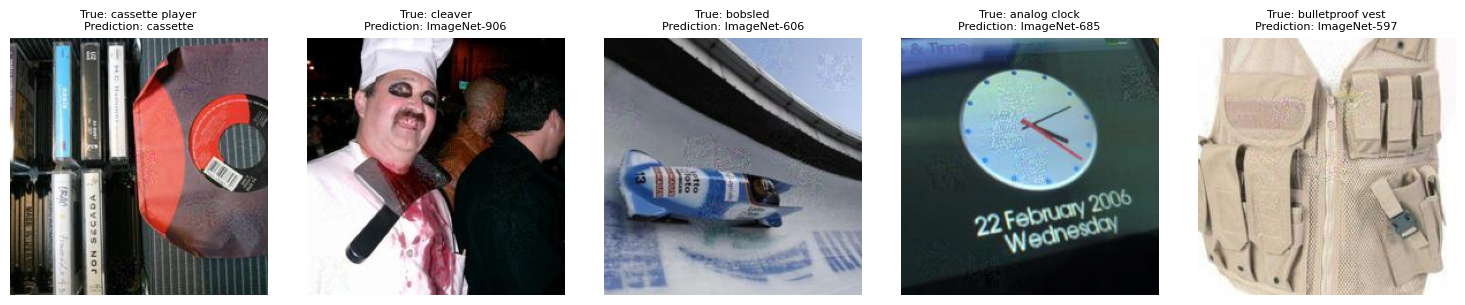

In [36]:
# 2. Visualize for the targetted Patch Attacked Dataset
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

## Task 5 : Transfer the attacks on DenseNet-121
In the previous 3 attacks we tried various strategies to attack a publicly posted Production Grade Model ResNet-34 We will now transfer the same attacks on DenseNet-121. We will use the same adversarial datasets generated earlier and record its performance.

In [37]:
# 1. Loading the DenseNet-121 Model
dense_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
dense_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 120MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [39]:
# 2. Evaluate against primary data set
dataset = torchvision.datasets.ImageFolder("./TestDataSet", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

stats = evaluate(dense_model, loader, device)
results["densenet121"]["Base"] = stats

Top-1 Accuracy: 74.80% (374/500)
Top-5 Accuracy: 93.60% (468/500)


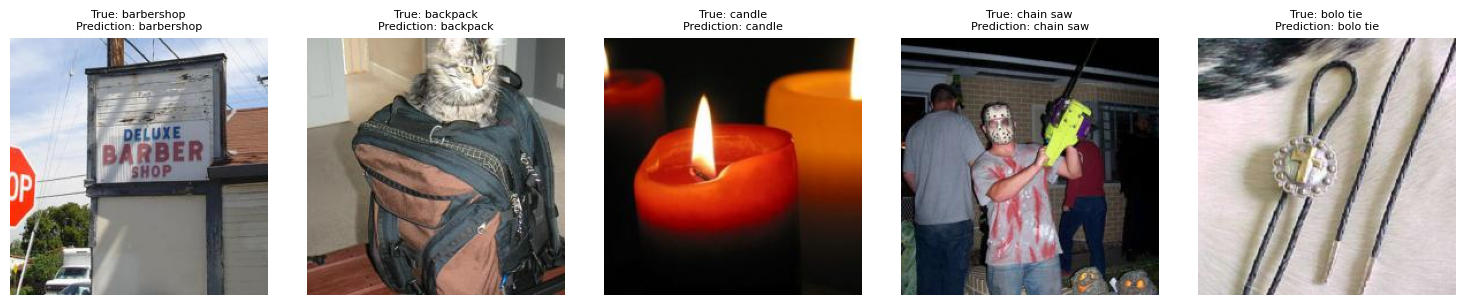

In [40]:
# Visualize for Base Performance against DenseNet-121
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [41]:
# 3. Evaluate against Attacked data set
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet1", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

stats = evaluate(dense_model, loader, device)
results["densenet121"]["FGSM"] = stats

Top-1 Accuracy: 51.00% (255/500)
Top-5 Accuracy: 79.00% (395/500)


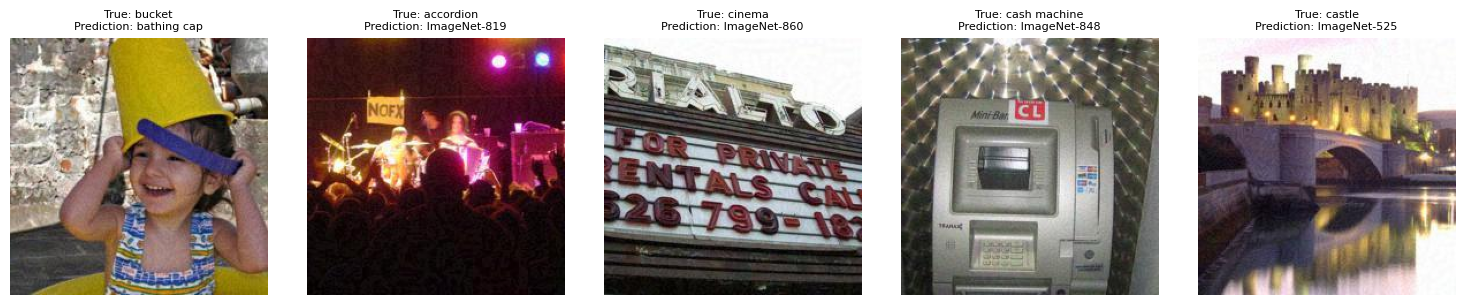

In [42]:
# Visualize for FGSM Performance against DenseNet-121
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [43]:
# 4. Evaluate against improved Attacked data set
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet2", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

stats = evaluate(dense_model, loader, device)
results["densenet121"]["MI-FGSM"] = stats

Top-1 Accuracy: 46.20% (231/500)
Top-5 Accuracy: 80.00% (400/500)


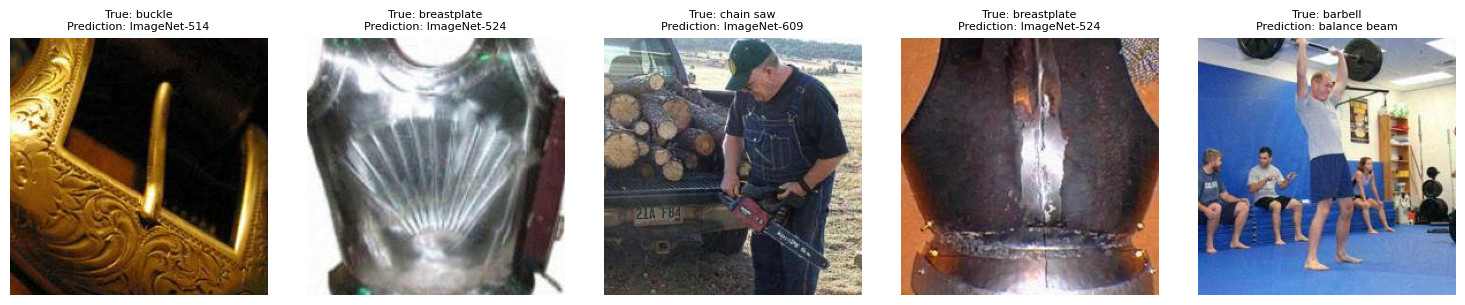

In [44]:
# Visualize for MI-FGSM Performance against DenseNet-121
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [45]:
# 5. Evaluate against patch improved Attacked data set
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet3", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

stats = evaluate(dense_model, loader, device)
results["densenet121"]["Patch MI-FGSM"] = stats

Top-1 Accuracy: 60.80% (304/500)
Top-5 Accuracy: 87.00% (435/500)


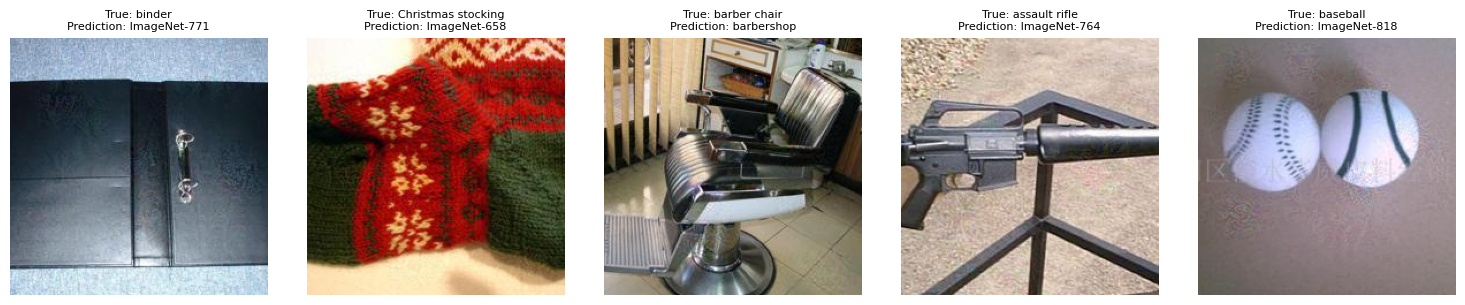

In [46]:
# Visualize for Patch MI-FGSM Performance against DenseNet-121
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [47]:
# 6. Evaluate against patch targetted Attacked data set
dataset = torchvision.datasets.ImageFolder("./Adversarial_TestSet4", transform=transform)
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

stats = evaluate(dense_model, loader, device)
results["densenet121"]["Patch Targetted"] = stats

Top-1 Accuracy: 67.00% (335/500)
Top-5 Accuracy: 91.20% (456/500)


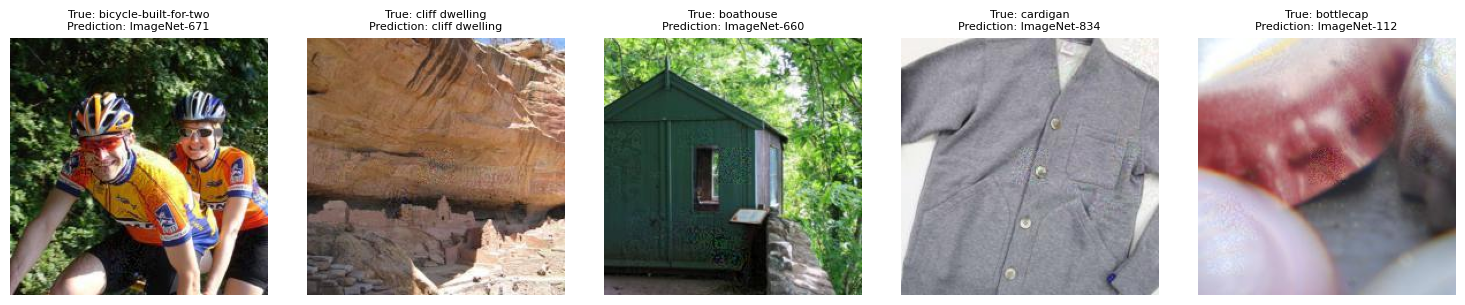

In [48]:
# Visualize for Patch Targetted Performance against DenseNet-121
idxs = random.sample(range(len(dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for ax, idx in zip(axes, idxs):
        img_norm, lbl_subset = dataset[idx]
        pred_im = model(img_norm.unsqueeze(0).to(device)).argmax(1).item()

        true_name = subset_names[lbl_subset]
        pred_name = subset_names[im_to_subset[pred_im]] \
                        if pred_im in im_to_subset else f"ImageNet-{pred_im}"

        ax.imshow((img_norm.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)).clamp(0,1).permute(1,2,0))
        ax.set_title(f"True: {true_name}\nPrediction: {pred_name}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

## Benchmarking Performance of both Models

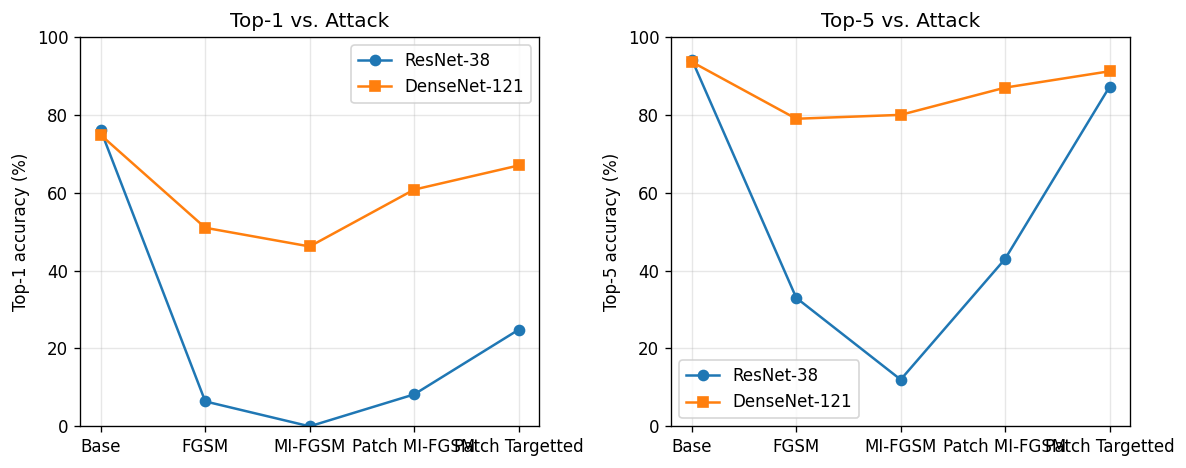

In [56]:
# Plotting the performance of both the models
attacks = ["Base", "FGSM", "MI-FGSM", "Patch MI-FGSM", "Patch Targetted"]

def metric_list(model: str, metric: str):
    return [results[model][atk][0][metric] for atk in attacks]

top1_resnet   = metric_list("resnet38",   "top1")
top1_densenet = metric_list("densenet121","top1")
top5_resnet   = metric_list("resnet38",   "top5")
top5_densenet = metric_list("densenet121","top5")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

# Top-1 plot
axes[0].plot(attacks, top1_resnet,   marker="o", label="ResNet-38")
axes[0].plot(attacks, top1_densenet, marker="s", label="DenseNet-121")
axes[0].set_ylabel("Top-1 accuracy (%)")
axes[0].set_title("Top-1 vs. Attack")
axes[0].set_ylim(0, 100)
axes[0].grid(alpha=0.3)
axes[0].legend()

# Top-5 plot
axes[1].plot(attacks, top5_resnet,   marker="o", label="ResNet-38")
axes[1].plot(attacks, top5_densenet, marker="s", label="DenseNet-121")
axes[1].set_ylabel("Top-5 accuracy (%)")
axes[1].set_title("Top-5 vs. Attack")
axes[1].set_ylim(0, 100)
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.tight_layout()
plt.show()


## Final Metrics
###Task 1 : Base Performance
- Top-1 Accuracy: 76.00% (380/500)
- Top-5 Accuracy: 94.20% (471/500)

###Task 2 : FGSM Attack
- Top-1 Accuracy: 6.40% (32/500)
- Top-5 Accuracy: 33.00% (165/500)

###Task 3 : MI-FGSM Attack
- Top-1 Accuracy: 0.00% (0/500)
- Top-5 Accuracy: 12.00% (60/500)

###Task 4 : Patch MI-FGSM Attack
- Top-1 Accuracy: 9.00% (45/500)
- Top-5 Accuracy: 42.60% (213/500)

###Task 5
#### Base Performance
- Top-1 Accuracy: 74.80% (374/500)
- Top-5 Accuracy: 93.60% (468/500)

#### FGSM Attack
- Top-1 Accuracy: 51.00% (255/500)
- Top-5 Accuracy: 79.00% (395/500)

#### MI-FGSM Attack
- Top-1 Accuracy: 46.40% (232/500)
- Top-5 Accuracy: 79.80% (399/500)

#### Patch MI-FGSM Attack
- Top-1 Accuracy: 60.20% (301/500)
- Top-5 Accuracy: 87.80% (439/500)

Both networks score similarly on clean images (≈ 75 % Top-1, 94 % Top-5), but DenseNet-121 is far sturdier under attack. A single-step FGSM slashes ResNet-38 to 6 % Top-1, while DenseNet still holds 51 %. Momentum-iterative FGSM is harsher: ResNet breaks completely (0 % Top-1, 12 % Top-5) yet DenseNet retains 46 % Top-1 and 80 % Top-5. Patch-based attacks hurt less—ResNet rebounds to 8 % (untargeted) and 25 % (targeted) Top-1, versus 61 % and 67 % for DenseNet—but still show DenseNet’s clear edge. Bottom line: MI-FGSM is the most damaging, ResNet-38 is highly fragile, and Top-5 accuracy can mask big Top-1 drops.
